In [0]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

# Pretrained GAN

Crappifying data

In [0]:
from PIL import Image, ImageDraw, ImageFont

In [0]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'crappy'

In [0]:
def crappify(fn,i):
    dest = path_lr/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, 96, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    w,h = img.size
    q = random.randint(10,70)
    ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
    img.save(dest, quality=q)

In [6]:
il = ImageList.from_folder(path_hr)
parallel(crappify, il.items)

For gradual resizing we can change the commented line here.

In [0]:
bs, size = 32, 128
# bs,size = 24,160
#bs,size = 8,256
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [0]:
def getData(bs, size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [0]:
generatorData = getData(bs, size)


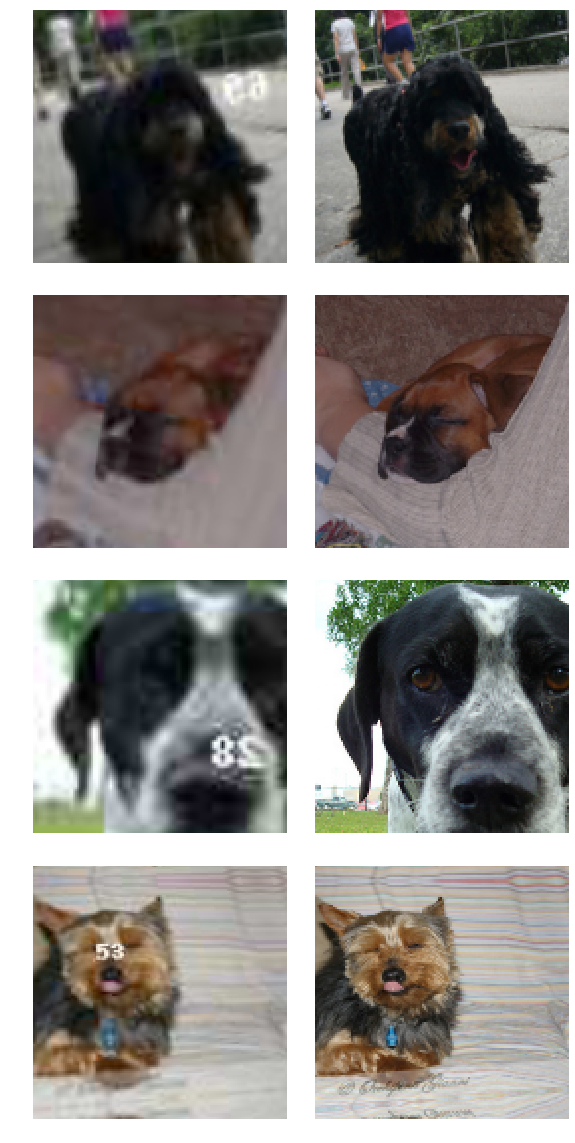

In [14]:
generatorData.show_batch(4)

In [0]:
wd = 1e-3
y_range = (-3.,3.)
loss_gen = MSELossFlat()

In [0]:
def createGeneratorLearner():
    return unet_learner(generatorData, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

In [0]:
#pre trained model
learn_gen = createGeneratorLearner()

In [16]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

In [0]:
learn_gen.unfreeze()

In [19]:
learn_gen.fit_one_cycle(3, slice(1e-6, 1e-3))

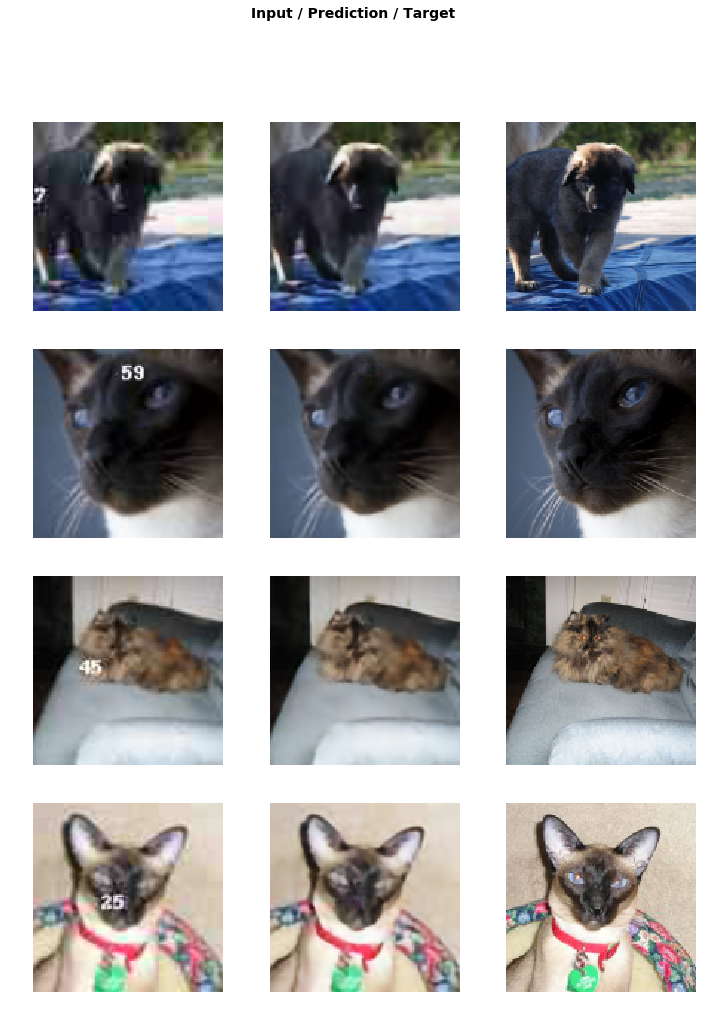

In [20]:
learn_gen.show_results(rows=4)

In [0]:

learn_gen.save('gen-pre2')

### Saving generated images

In [0]:
learn_gen.load('gen-pre2');

In [0]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [0]:
path_gen.mkdir(exist_ok = True)

In [0]:
def savePredictions(dataLoader):
  i = 0
  names = dataLoader.dataset.items
  
  for batch in dataLoader:
    predictions = learn_gen.pred_batch(batch=batch, reconstruct=True)
    for obj in predictions:
      obj.save(path_gen/names[i].name)
      i += 1

In [0]:
savePredictions(generatorData.fix_dl)

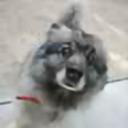

In [29]:
PIL.Image.open(path_gen.ls()[0])

## Training the Critic

In [31]:
learn_gen=None
gc.collect() #  that tells Python to do memory garbage collection

7

Pretrain the critic on crappy vs not crappy.

In [0]:
def getCriticData(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    labelList = src.label_from_folder(classes=classes)
    data = (labelList.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [0]:
criticData = getCriticData([name_gen, 'images'], bs=bs, size=size)

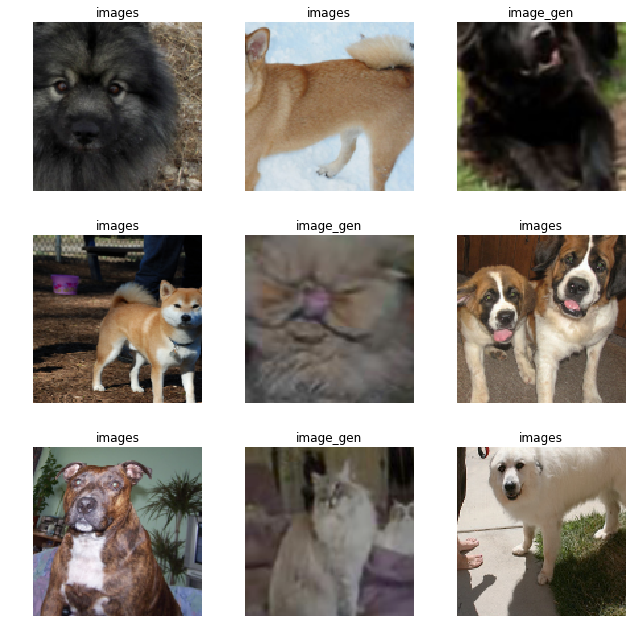

In [34]:
criticData.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [0]:
criticLoss = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [0]:
def createCriticLearner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=criticLoss, wd=wd)

In [0]:
learn_critic = createCriticLearner(criticData, accuracy_thresh_expand)

In [38]:
learn_critic.fit_one_cycle(6, 1e-3)

In [0]:
learn_critic.save('critic-pre2')

## GAN


Now we'll combine those pretrained model in a GAN.

In [40]:
learn_crit=None
learn_gen=None
gc.collect()

15754

In [0]:
criticData = getCriticData(['crappy', 'images'], bs=bs, size=size)

In [0]:
learn_critic = createCriticLearner(criticData, metrics=None).load('critic-pre2')

In [0]:
learn_generator = createGeneratorLearner().load('gen-pre2')

To define a GAN Learner, we just have to specify the learner objects foor the generator and the critic. The switcher is a callback that decides when to switch from discriminator to generator and vice versa. Here we do as many iterations of the discriminator as needed to get its loss back < 0.5 then one iteration of the generator.

The loss of the critic is given by learn_crit.loss_func. We take the average of this loss function on the batch of real predictions (target 1) and the batch of fake predicitions (target 0).

The loss of the generator is weighted sum (weights in weights_gen) of learn_crit.loss_func on the batch of fake (passed throught the critic to become predictions) with a target of 1, and the learn_gen.loss_func applied to the output (batch of fake) and the target (corresponding batch of superres images).

In [0]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)

learn = GANLearner.from_learners(learn_generator, learn_critic, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)

learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [0]:
lr = 1e-4

In [54]:
learn.fit(2,lr) #it should be 40 epochs

In [0]:
learn.save('gan-1c')

In [0]:
learn.data = getData(16,192)

In [57]:
learn.fit(1,lr/2) #it should be 10 epochs

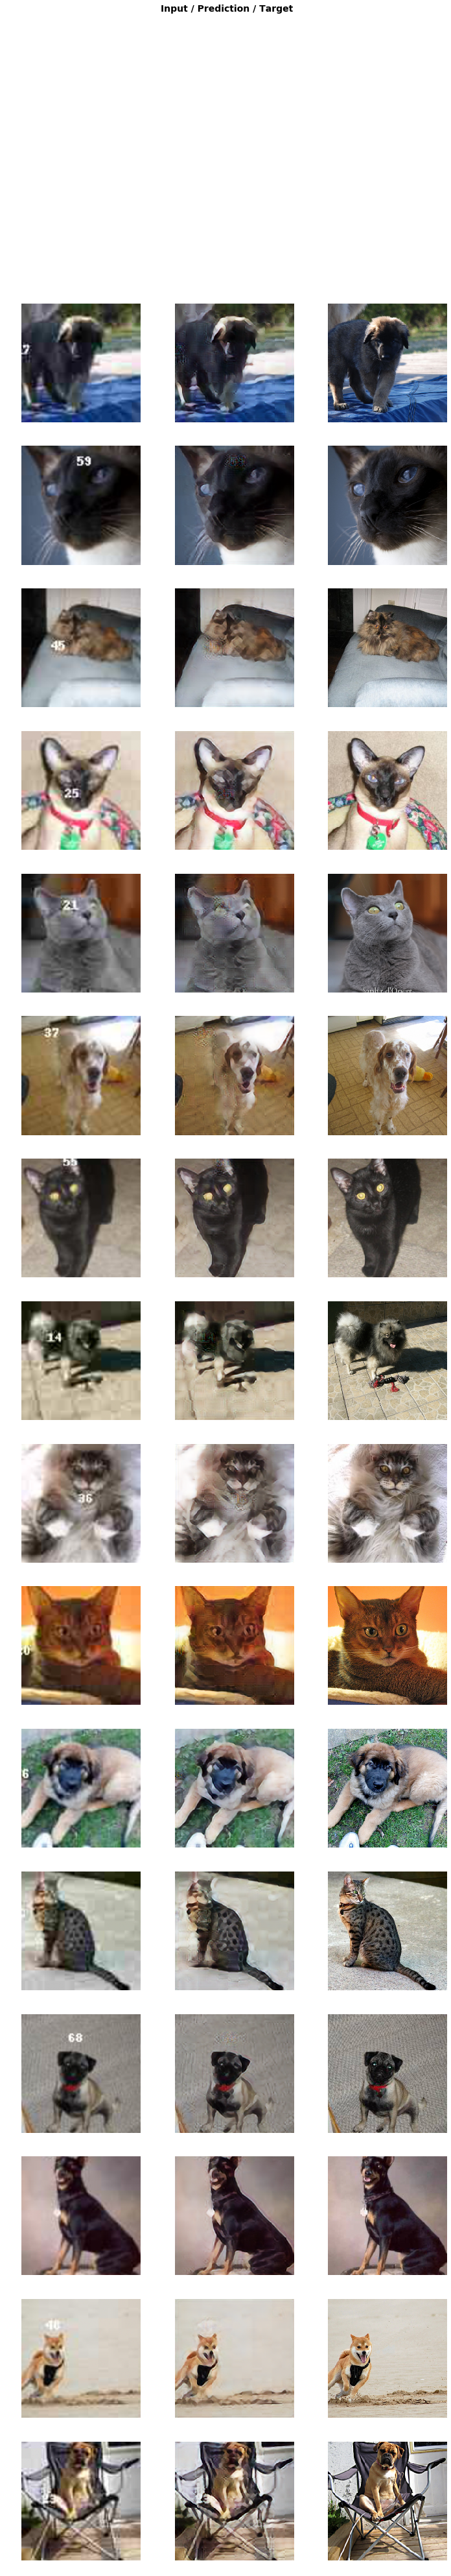

In [58]:
learn.show_results(rows=16)

In [0]:
learn.save('gan-1c')